# Sentiment Analysis on Indonesian Tweets about PPKM  
### Using SentenceTransformer Embeddings, Logistic Regression, and FAISS Similarity Search  
Author: *Sumitra Adriansyah*  


## 1. Pendahuluan
Notebook ini merupakan implementasi sentimen analisis terhadap tweet berbahasa Indonesia terkait kebijakan PPKM.

Pipeline yang digunakan:
1. Data loading & cleaning  
2. Exploratory Data Analysis (EDA)  
3. Embedding extraction menggunakan SentenceTransformer  
4. Training model Logistic Regression  
5. Evaluasi  
6. Pembuatan FAISS index untuk similarity search  
7. Prediksi contoh input  

Notebook ini dibuat untuk memenuhi persyaratan **Technical Test – Data Scientist NoLimit Indonesia**.


# 2. Instalation & Load libraries

In [1]:
!pip install -q transformers datasets accelerate sentencepiece scikit-learn pandas matplotlib seaborn datasets evaluate scikit-learn faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 45.1 MB/s eta 0:00:00


In [2]:
!pip install -q huggingface_hub

In [26]:
from datasets import Dataset
import pandas as pd
import numpy as np
import re
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import EvalPrediction
from tqdm.auto import tqdm
from datasets import Dataset
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
import faiss
import joblib
import faiss
import os
import json
from huggingface_hub import HfApi
from google.colab import files

## 3. Load Dataset
Dataset digunakan yaitu INA Tweets PPKM yang sudah dilabeli secara manual.

In [4]:
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving INA_TweetsPPKM_Labeled_Pure.csv to INA_TweetsPPKM_Labeled_Pure.csv
User uploaded file "INA_TweetsPPKM_Labeled_Pure.csv" with length 5250754 bytes


In [5]:
df = pd.read_csv("INA_TweetsPPKM_Labeled_Pure.csv", sep="\t")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23644 entries, 0 to 23643
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       23644 non-null  object
 1   User       23644 non-null  object
 2   Tweet      23644 non-null  object
 3   sentiment  23644 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 739.0+ KB


,Date,User,Tweet,sentiment
0,2022-03-31 14:32:04+00:00,pikobar_jabar,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,2022-03-31 09:26:00+00:00,inewsdotid,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,2022-03-31 05:02:34+00:00,vdvc_talk,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,2022-03-30 14:23:10+00:00,pikobar_jabar,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,2022-03-30 11:28:57+00:00,tvOneNews,Kementerian Agama menerbitkan Surat Edaran Nom...,1


# 4. Exploratory Data Analysis (EDA)

In [6]:
print(f'jumlah data: {len(df)}')
df.head(50)

jumlah data: 23644


,Date,User,Tweet,sentiment
0,2022-03-31 14:32:04+00:00,pikobar_jabar,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,2022-03-31 09:26:00+00:00,inewsdotid,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,2022-03-31 05:02:34+00:00,vdvc_talk,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,2022-03-30 14:23:10+00:00,pikobar_jabar,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,2022-03-30 11:28:57+00:00,tvOneNews,Kementerian Agama menerbitkan Surat Edaran Nom...,1
5,2022-03-30 11:21:18+00:00,lampungpost_,"Kapasitas tempat ibadah, termasuk masjid, yang...",1
6,2022-03-30 08:00:19+00:00,akusehatklinik,"Halo Sobat Sehat\n\nDengan adanya kondisi ini,...",1
7,2022-03-30 04:35:57+00:00,matamilenialID,Mitigasi Penting untuk Cegah Penyebaran Varian...,1
8,2022-03-30 04:21:08+00:00,lampungpostid,Sebanyak 5 (lima) kabupaten di Provinsi Lampun...,1
9,2022-03-30 03:16:52+00:00,gemaposID,Komentar Satgas Penanganan Covid-19 Tentang Bu...,1


In [ ]:
df.isnull().sum()

,0
Date,0
User,0
Tweet,0
sentiment,0


In [ ]:
df.duplicated(subset='Tweet').sum()

np.int64(158)

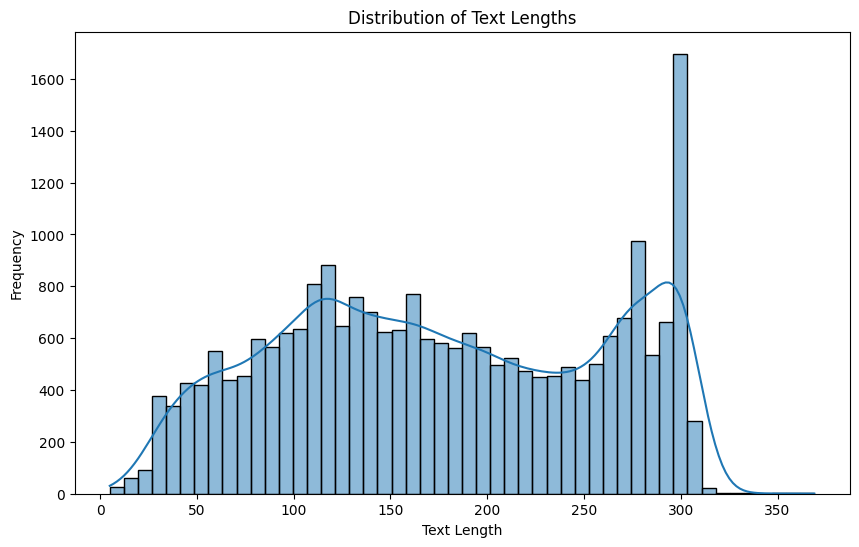

In [ ]:
df['text_length'] = df['Tweet'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

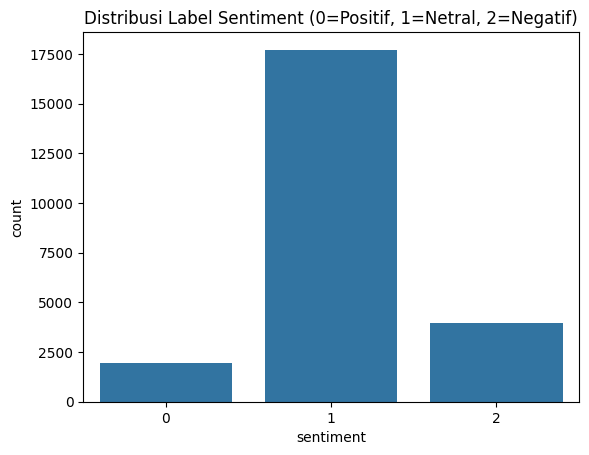

In [ ]:
sns.countplot(data=df, x="sentiment")
plt.title("Distribusi Label Sentiment (0=Positif, 1=Netral, 2=Negatif)")
plt.show()

/tmp/ipython-input-1616225905.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['YearMonth'] = df['Date'].dt.to_period('M')


<Figure size 1500x700 with 0 Axes>

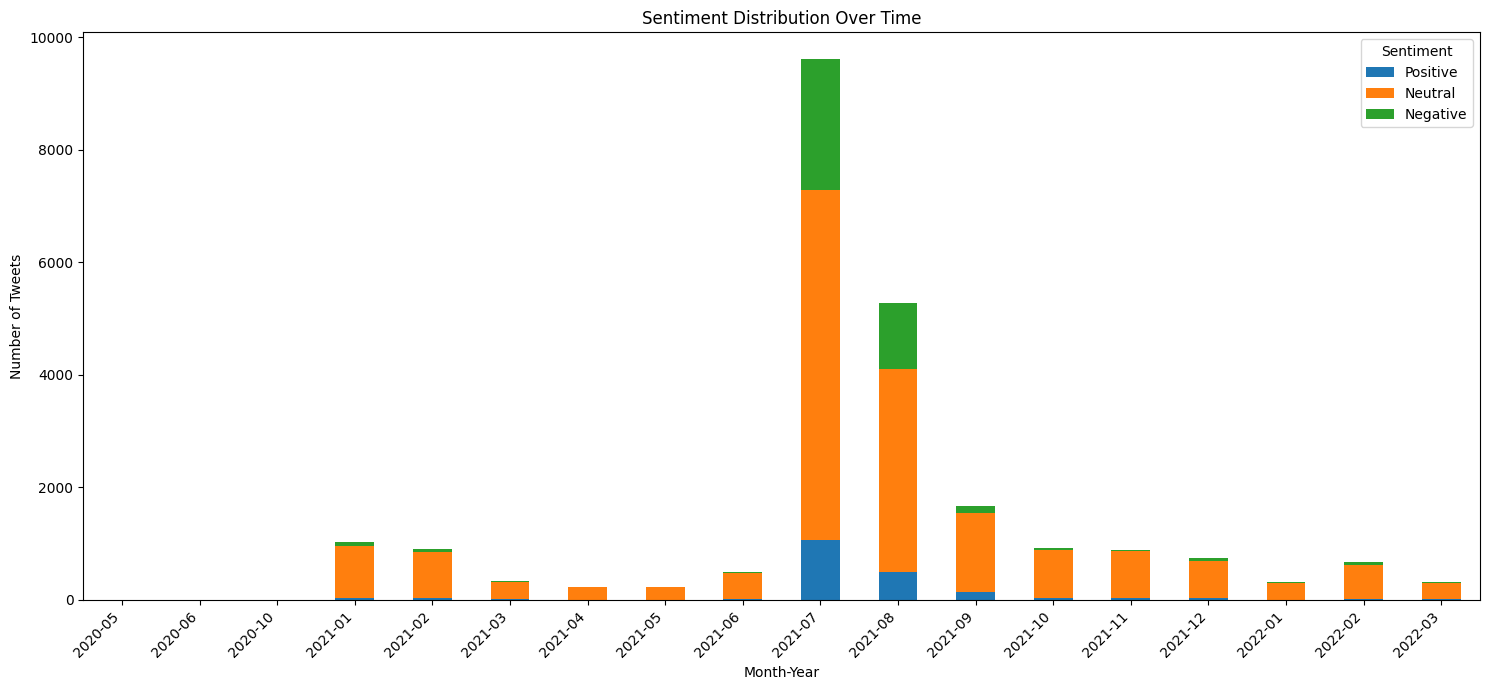

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['YearMonth'] = df['Date'].dt.to_period('M')

sentiment_over_time = df.groupby(['YearMonth', 'sentiment']).size().unstack(fill_value=0)
sentiment_over_time.index = sentiment_over_time.index.astype(str)

plt.figure(figsize=(15, 7))
sentiment_over_time.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Sentiment Distribution Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment', labels=['Positive', 'Neutral', 'Negative'])
plt.tight_layout()
plt.show()

## 5. Data Cleaning & Preprocessing
Tahapan:
- Menghapus URL, mention, hashtag  
- Lowercasing  
- Menghapus duplikasi  
- Menambah kolom text_length

In [7]:
df = df[['Tweet', 'sentiment']].dropna().reset_index(drop=True)
df['sentiment'] = df['sentiment'].astype(int)

def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['tweet'] = df['Tweet'].apply(clean_text)
df = df[['tweet','sentiment']]
df.head()

,tweet,sentiment
0,Ketahui informasi pembagian PPKM di wilayah Ja...,1
1,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,Ketahui informasi pembagian PPKM di wilayah Ja...,1
4,Kementerian Agama menerbitkan Surat Edaran Nom...,1


In [8]:
df["tweet"] = df["tweet"].str.lower()
df.head()

,tweet,sentiment
0,ketahui informasi pembagian ppkm di wilayah ja...,1
1,tempat ibadah di wilayah ppkm level 1 boleh be...,1
2,"juru bicara satgas covid-19, wiku adisasmito m...",1
3,ketahui informasi pembagian ppkm di wilayah ja...,1
4,kementerian agama menerbitkan surat edaran nom...,1


In [9]:
df[df.duplicated(subset='tweet')].head()

,tweet,sentiment
10,ketahui informasi pembagian ppkm di wilayah ja...,1
26,ketahui informasi pembagian ppkm di wilayah ja...,1
28,ketahui informasi pembagian ppkm di wilayah ja...,1
29,ketahui informasi pembagian ppkm di wilayah ja...,1
31,"rakor evaluasi ppkm luar jawa-bali, andi sudir...",1


In [10]:
df = df.drop_duplicates(subset='tweet').reset_index(drop=True)

In [11]:
print("Jumlah duplikasi setelah dibersihkan:", df.duplicated(subset='tweet').sum())
print("Shape dataset setelah drop duplikat:", df.shape)

Jumlah duplikasi setelah dibersihkan: 0
Shape dataset setelah drop duplikat: (21401, 2)


In [12]:
df = df.rename(columns={
    "tweet": "text",
    "sentiment": "label"
})

df["label"] = df["label"].astype(int)

print(df.shape)
df.head()

(21401, 2)


,text,label
0,ketahui informasi pembagian ppkm di wilayah ja...,1
1,tempat ibadah di wilayah ppkm level 1 boleh be...,1
2,"juru bicara satgas covid-19, wiku adisasmito m...",1
3,ketahui informasi pembagian ppkm di wilayah ja...,1
4,kementerian agama menerbitkan surat edaran nom...,1


## 6. Embedding Extraction (SentenceTransformer)
Menggunakan model multilingual dari Hugging Face:
- paraphrase-multilingual-mpnet-base-v2

In [13]:
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
print("Model loaded successfully.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded successfully.


In [14]:
embeddings = model.encode(df["text"].tolist(), show_progress_bar=True)
embeddings.shape

Batches:   0%|          | 0/669 [00:00<?, ?it/s]

(21401, 768)

## 7. Training Model Klasifikasi

In [15]:
X_train, X_test, y_train, y_test = train_test_split( embeddings, df["label"], test_size=0.2, random_state=42)

In [16]:
clf = LogisticRegression(
    max_iter=300,
    class_weight="balanced",
    solver="lbfgs",
    n_jobs=-1
)

clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=300, n_jobs=-1)

## 8. Evaluasi Kinerja Model

In [17]:
y_pred = clf.predict(X_test)

print("CLASSIFICATION REPORT RESULT TRAIN")
print(classification_report(y_test, y_pred))

CLASSIFICATION REPORT RESULT TRAIN
              precision    recall  f1-score   support

           0       0.41      0.75      0.53       406
           1       0.95      0.77      0.85      3062
           2       0.63      0.81      0.71       813

    accuracy                           0.78      4281
   macro avg       0.66      0.78      0.70      4281
weighted avg       0.84      0.78      0.79      4281



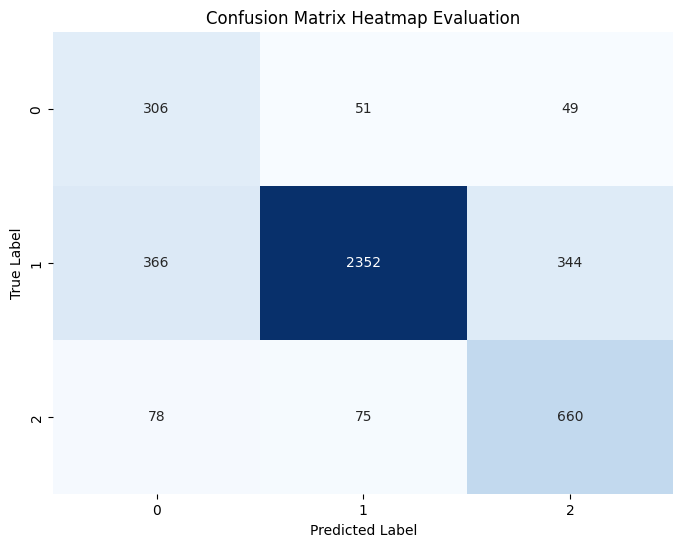

In [18]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap Evaluation')
plt.show()

## 9. FAISS Similarity Search Index

In [19]:
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings))

print("FAISS index successfully built.")

FAISS index successfully built.


## 10. Prediksi & Nearest Neighbor Search

In [20]:
def sentiment_predict(text):
    emb = model.encode([text])

    pred_label = clf.predict(emb)[0]
    pred_prob = clf.predict_proba(emb).max()

    D, I = index.search(np.array(emb), k=1)
    nearest = df.iloc[I[0][0]]

    print("\n==============================")
    print("Input:", text)
    print("Prediction:", pred_label)
    print("Confidence:", round(float(pred_prob), 4))

    print("\nNearest Training Example:")
    print("Tweet:", nearest['text'])
    print("Label:", nearest['label'])
    print("==============================\n")

## 11. Save Model

In [22]:
os.makedirs("saved_model", exist_ok=True)

model.save("saved_model/sentence_transformer")

joblib.dump(clf, "saved_model/classifier.pkl")

faiss.write_index(index, "saved_model/faiss.index")

with open("saved_model/metadata.json", "w") as f:
    json.dump({"description": "PPKM Sentiment Model"}, f)

print("Model saved successfully!")

Model saved successfully!


In [25]:
!zip -r saved_model.zip saved_model
files.download("saved_model.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/faiss.index (deflated 7%)
  adding: saved_model/classifier.pkl (deflated 5%)
  adding: saved_model/metadata.json (stored 0%)
  adding: saved_model/sentence_transformer/ (stored 0%)
  adding: saved_model/sentence_transformer/README.md (deflated 61%)
  adding: saved_model/sentence_transformer/tokenizer.json (deflated 76%)
  adding: saved_model/sentence_transformer/tokenizer_config.json (deflated 75%)
  adding: saved_model/sentence_transformer/sentencepiece.bpe.model (deflated 49%)
  adding: saved_model/sentence_transformer/sentence_bert_config.json (deflated 9%)
  adding: saved_model/sentence_transformer/config_sentence_transformers.json (deflated 40%)
  adding: saved_model/sentence_transformer/1_Pooling/ (stored 0%)
  adding: saved_model/sentence_transformer/1_Pooling/config.json (deflated 59%)
  adding: saved_model/sentence_transformer/special_tokens_map.json (deflated 85%)
  adding: saved_model/sentence_transformer/config.json (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `ppkm-sentiment-model` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been save

In [29]:
api = HfApi()
api.upload_folder(
    folder_path="saved_model",
    path_in_repo=".",
    repo_id="sumitraadrian/ppkm-sentiment-model",
    repo_type="model"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...r/sentencepiece.bpe.model: 100%|##########| 5.07MB / 5.07MB            

  ...ransformer/tokenizer.json: 100%|##########| 17.1MB / 17.1MB            

  ...sformer/model.safetensors:   1%|1         | 15.7MB / 1.11GB            

  ...aved_model/classifier.pkl:   1%|          |   162B / 19.3kB            

  ...t/saved_model/faiss.index:   1%|          |  552kB / 65.7MB            

CommitInfo(commit_url='https://huggingface.co/sumitraadrian/ppkm-sentiment-model/commit/7d6d3404fa38752f2fb36601ec56138467f721b5', commit_message='Upload folder using huggingface_hub', commit_description='', oid='7d6d3404fa38752f2fb36601ec56138467f721b5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sumitraadrian/ppkm-sentiment-model', endpoint='https://huggingface.co', repo_type='model', repo_id='sumitraadrian/ppkm-sentiment-model'), pr_revision=None, pr_num=None)

## 12. Contoh Prediksi

In [ ]:
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
if file_name.endswith(".csv"):
    input_df = pd.read_csv(file_name)
elif file_name.endswith(".txt"):
    input_df = pd.read_csv(file_name, sep="\n", header=None, names=["text"])
else:
    raise ValueError("Format file harus .csv atau .txt")

for i, row in input_df.iterrows():
    sentiment_predict(row["text"])

Saving small_sample_data.csv to small_sample_data.csv

Input: krn masih ingat, 2019 itu sampai bbrp bulan pertengahan tahunsh ada hujan. jaman2 covid pkkm jg ada hujan deras pas kemarau. trs 2021 - 2023 msh ingat bgt, lebaran itu bulan mei kan (klo g slh). pas itu pergi siang2 keluar mau nyari hp.
Prediction: 0
Confidence: 0.5943

Nearest Training Example:
Tweet: tak terhalangi oleh ppkm tapi sungkan mengelak hujan..., akupulang akugakbawasandal masamasukkantororangbecek2an
Label: 2


Input: apa itu obat molnupiravir viral viraltiktok viraltwitter newsupdate newsupdates news beritaterkini berita beritaviral beritanasional beritajakarta beritaharian ppkmlevel2 ppkm vaksinasi vaksin covid19 covid_19 covid molnupiravir merck
Prediction: 1
Confidence: 0.9843

Nearest Training Example:
Tweet: apa itu obat molnupiravir viral viraltiktok viraltwitter newsupdate newsupdates news beritaterkini berita beritaviral beritanasional beritajakarta beritaharian ppkmlevel2 ppkm vaksinasi vaksin covid19 

## 13. Kesimpulan

- Sentimen Terkait PKKM cenderung didominasi oleh sentimen netral dengan jumlah 17500 data.
- Rentang sentimen memuncak pada bulan juli 2021 dan perlahan menurun. Hal ini menunjukkan pembahasan terkait PKKM banyak dibicarakan pada kurun waktu tersebut, sesuai dengan keadaan realita yang sedang meningkat kasus COVID-19 di Indonesia pada waktu tersebut.
- Model berbasis SentenceTransformer menghasilkan performa klasifikasi yang baik.  
- Akurasi model cukup baik dengan 78%.
- FAISS index membantu memberikan interpretabilitas melalui nearest neighbor.